# Capstone Project #1: Stastistical Inference & Analysis

### Primary Questions:
1. Do any of the customer behaviors tend to impact their repeat purchase decision?
2. Do any of attributes from first order tend to impact their next purchase decision? 
2. Is there a significant difference between store newsletter subscriber and unsubscribers when compared their repeat purchase rate? If yes/no, what does this mean for future marketing strategies?


In [1]:
# from google.cloud import bigquery
# from pandas.io import gbq
# from google.colab import auth
# auth.authenticate_user()
import os
import glob
import datetime 
import pandas as pd
import numpy as np
import sys

import pandas_profiling as pp
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Common Model Helpers
from sklearn import preprocessing
!pip install category_encoders
from category_encoders import TargetEncoder
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.model_selection import ParameterGrid

# from scipy.spatial.distance import cdist
# from sklearn import cluster, tree, decomposition

#Common Model Algorithms
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source

# from sklearn.learning_curve import validation_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from sklearn import metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score


#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

     |████████████████████████████████| 81kB 2.2MB/s 


In [2]:
# find the unique values in each column
def unique_counts(customer):
    for i in customer.columns:
        count=customer[i].nunique()
        print(i, ':', count)
        

#print missing value table
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values ', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns 

## Load data from data preparation step


In [3]:
from google.colab import files
uploaded = files.upload()

Saving clv_file.csv to clv_file.csv


In [7]:
customers = pd.read_csv('clv_file.csv')
customers.shape

(536811, 26)

In [8]:
# drop customers with first order < =0
customers = customers[customers['order_revenue'] > 0]
customers.shape

(532565, 26)

In [9]:
customers.rename(columns={'order_revenue':
                   'first_order_revenue',
                  'total_discounts':
                   'first_order_discount' }, inplace= True)
customers['revenue_12m']=customers['revenue_12m'].astype(float)
customers['first_order_discount']=customers['first_order_discount'].astype(float)
customers['first_order_revenue']=customers['first_order_revenue'].astype(float)

# add new day_of_week column
customers['order_date']=pd.to_datetime(customers['order_date'])
customers['day_of_week']=customers['order_date'].dt.dayofweek 
customers['day_of_week'] =customers['day_of_week'].astype(str)


# create target column repeat_purchase
# customers['repeat_purchase'] = ~(customers.order_count_12m < 2)
customers['repeat_purchase'] = np.where(customers.order_count_12m >1,  1, 0)

In [10]:
customers['province_code'].fillna("unknown", inplace = True) 
customers['country_code'].fillna("unknown", inplace = True) 


cols_to_fill = ['utm_content','landing_site','utm_term','utm_campaign', 'utm_medium','utm_source', 'referring_site', 'AE', 'DD', 'SP']
for i in cols_to_fill:
  customers[i+'_known'] = customers[i].notnull()

cols_to_drop=['landing_site_ref','tags', 'utm_term','utm_content','landing_site',
         'utm_campaign','utm_medium','utm_source','referring_site','AE', 'DD', 'SP']
customers.drop(cols_to_drop, axis=1, inplace=True)

## Check stats for numeric variables

In [11]:
customers.describe()

,uid,order_id,first_order_revenue,first_order_discount,item_qty,unique_item,revenue_12m,order_count_12m,repeat_purchase
count,5.325650e+05,5.325650e+05,532565.000000,532565.000000,532565.000000,532565.0,532565.000000,532565.000000,532565.000000
mean,7.763938e+14,8.554080e+11,67.734413,0.094273,1.033277,1.0,96.623003,1.385964,0.233639
std,5.323107e+18,6.055553e+11,81.383033,1.240837,0.275652,0.0,190.817455,0.922873,0.423146
min,-9.220000e+18,3.633358e+09,0.690000,0.000000,1.000000,1.0,0.690000,1.000000,0.000000
25%,-4.600000e+18,5.220000e+11,25.000000,0.000000,1.000000,1.0,35.000000,1.000000,0.000000
50%,1.270000e+15,5.600000e+11,50.000000,0.000000,1.000000,1.0,65.000000,1.000000,0.000000
75%,4.610000e+18,1.710000e+12,85.000000,0.000000,1.000000,1.0,105.000000,1.000000,0.000000
max,9.220000e+18,2.430000e+12,21210.000000,99.900000,50.000000,1.0,51030.000000,37.000000,1.000000


## Check numberic variables distribution by creating density plots

In [12]:
def density3(df1, df2,df3):
  #input shape df['col']
  fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,8))
  g1=sns.distplot(df1, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0])
  axes[0].set_title('Density plot of order_count_12m')

  g2=sns.distplot(df2, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},ax=axes[1])
  axes[1].set_title('Density plot of revenue_12m')

  g3=sns.distplot(df3, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},ax=axes[2])
  axes[2].set_title('Density plot of first_order_revenue')

  return g1, g2, g3

def density4(df1, df2,df3):
  #input shape df['col']
  fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,8))
  g1=sns.distplot(df1, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axes[0])
  axes[0].set_title('Log Density plot of order_count_12m')

  g2=sns.distplot(df2, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},ax=axes[1])
  axes[1].set_title('Log Density plot of revenue_12m')

  g3=sns.distplot(df3, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},ax=axes[2])
  axes[2].set_title('Log Density plot of first_order_revenue')

  return g1, g2, g3




(<matplotlib.axes._subplots.AxesSubplot at 0x7f96cc954208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f96ce9d4080>)

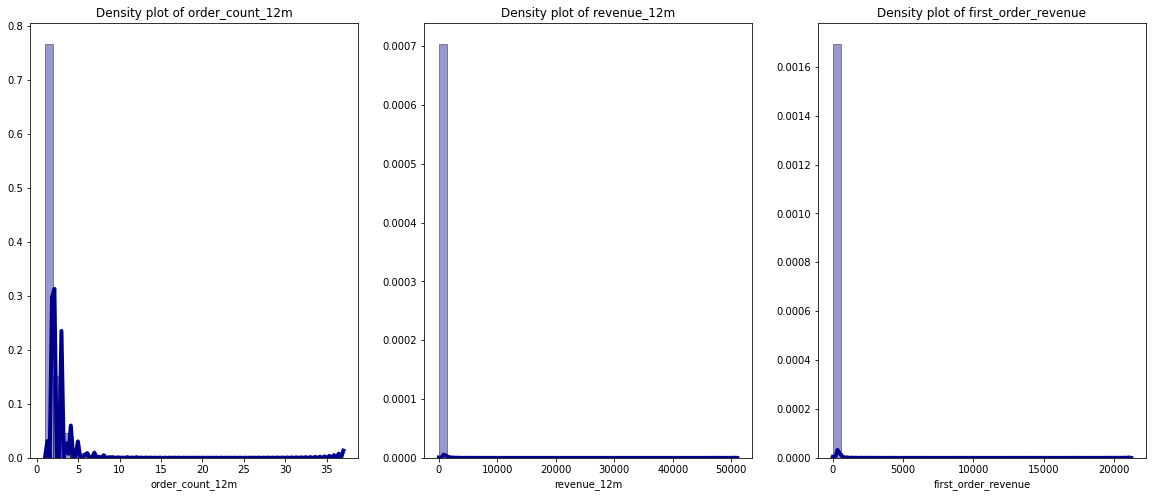

In [13]:
density3(customers['order_count_12m'], 
         customers['revenue_12m'],
         customers['first_order_revenue'])

**Highly skewed! from the plots above**

### Let's plot the log distribution

(<matplotlib.axes._subplots.AxesSubplot at 0x7f380eb4c668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f380e40c278>)

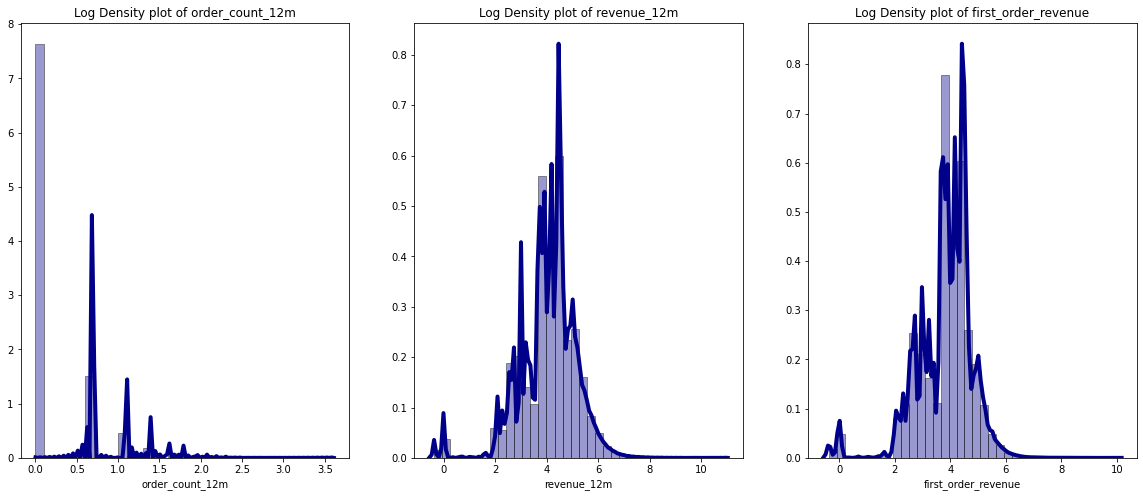

In [13]:
density4(np.log(customers['order_count_12m']), np.log(customers['revenue_12m']),np.log(customers['first_order_revenue']) )

**Two variables get closer to gaussian distribution after log transformation**

### Let look at the log distribution for repeat and single purchasers separately

(<matplotlib.axes._subplots.AxesSubplot at 0x7f380dfc2278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f380df8d780>)

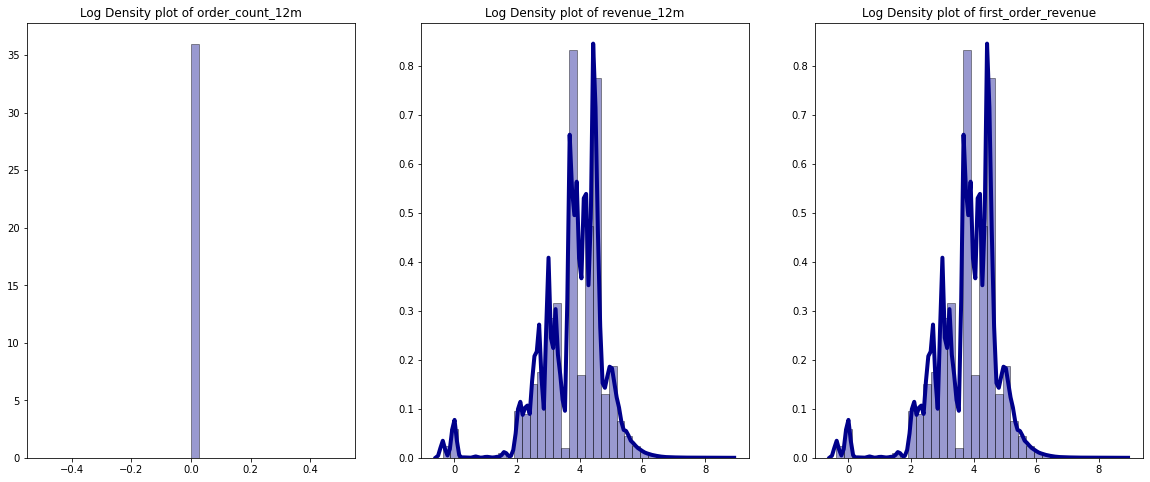

In [15]:
density4(np.log(customers.loc[customers['repeat_purchase']==0,['order_count_12m']]), 
         np.log(customers.loc[customers['repeat_purchase']==0,['revenue_12m']]),
         np.log(customers.loc[customers['repeat_purchase']==0,['first_order_revenue']])
         )

(<matplotlib.axes._subplots.AxesSubplot at 0x7f380dc417b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f380e1ec898>)

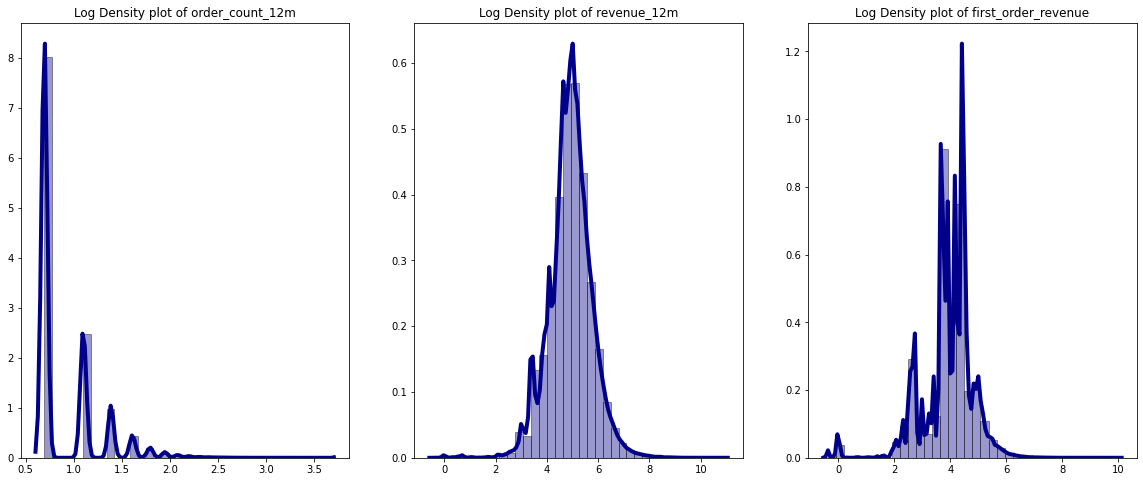

In [17]:
density4(np.log(customers.loc[customers['repeat_purchase']==1,['order_count_12m']]), 
         np.log(customers.loc[customers['repeat_purchase']==1,['revenue_12m']]),
         np.log(customers.loc[customers['repeat_purchase']==1,['first_order_revenue']])
                )

**revenue_12m variable of repeat purchaser are even closer to guassian distribution comparing to single purchaser's**

**The plots tell us if log tranformation needs to be applied if some models require normal distributed features in the further steps**

In [16]:
df2 = customers[['order_count_12m','revenue_12m','first_order_revenue','repeat_purchase']]
for i in df2.drop('repeat_purchase', axis=1).columns:
    df2['log_{0}'.format(i)] = np.log(customers[i])
df2.columns

Index(['order_count_12m', 'revenue_12m', 'first_order_revenue',
       'repeat_purchase', 'log_order_count_12m', 'log_revenue_12m',
       'log_first_order_revenue'],
      dtype='object')

## Compare repeat purchasers and single purchaser on the same plots

2. Do any of attributes from first order tend to impact their next purchase decision? 

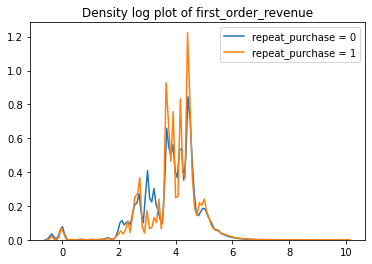

In [22]:
# plot first purchase 
sns.distplot(repeat_0[['log_first_order_revenue']], hist=False,label='repeat_purchase = 0')
sns.distplot(repeat_1[['log_first_order_revenue']], hist=False,label='repeat_purchase = 1')
plt.title('Density log plot of first_order_revenue')
plt.legend()

**There is a noticable difference rougtly between 2.5 - 3.0 on X axis. Features can be created to reflect this information and we can test whether those features are useful to improve our models or not via modeling section**

### Visualize log 12 month CLV vs log first order value

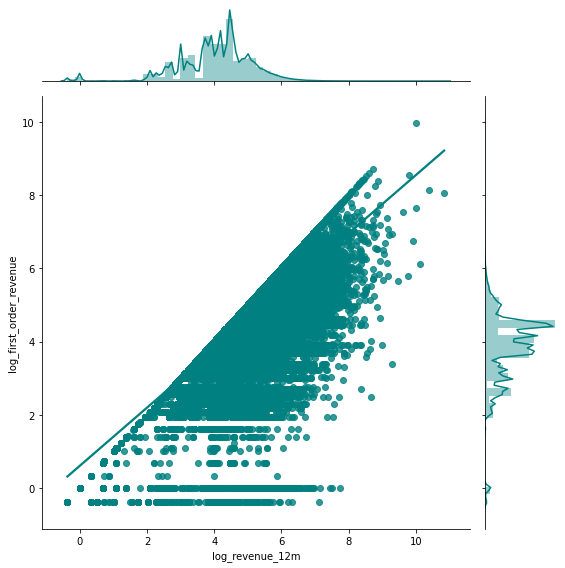

In [17]:
sns.jointplot(x='log_revenue_12m', y='log_first_order_revenue', data=df2, kind='reg', color='teal', size=8);

**There is a kind of linear relattion**


### Let's check correlation

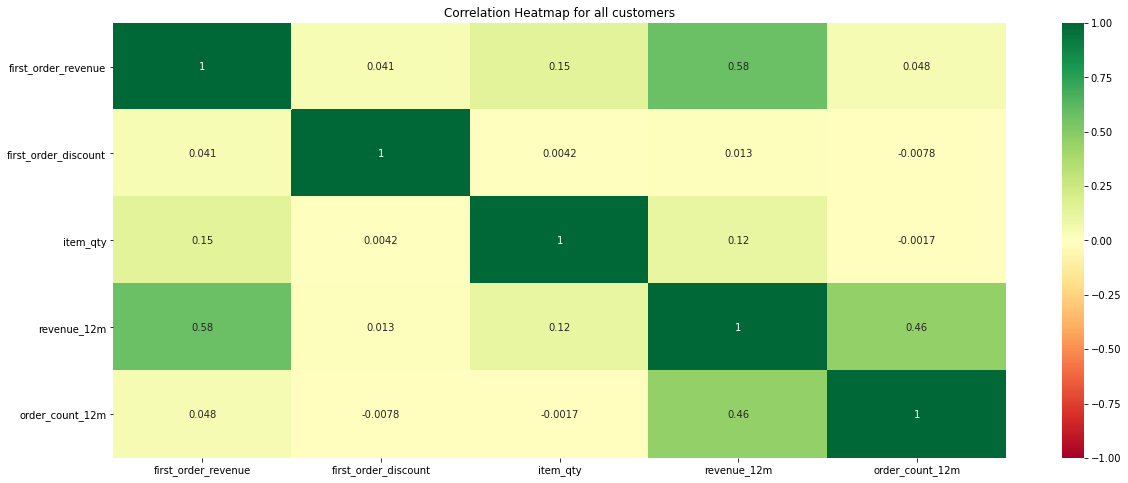

In [18]:
corr = customers[['first_order_revenue','first_order_discount','item_qty','revenue_12m','order_count_12m']].corr()
# fig, axes = plt.subplots(1, 2,figsize=(20,8))
# sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1,ax=axes[0])  
# axes[0].title.set_text('Correlation Heatmap for all purchasers ')

fig, ax= plt.subplots(figsize=(20, 8))
ax = sns.heatmap(corr, annot= True, cmap='RdYlGn', vmin=-1, vmax=1)
ax.title.set_text('Correlation Heatmap for all customers')

3. Is there a significant difference between store newsletter subscriber and unsubscribers when compared their repeat purchase rate? If yes/no, what does this mean for future marketing strategies?

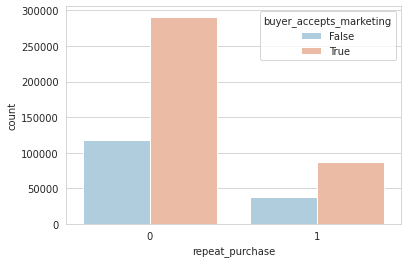

In [21]:
sns.set_style('whitegrid')
sns.countplot(x='repeat_purchase',hue='buyer_accepts_marketing',data=customers,palette='RdBu_r')

**There is no obvious impact from buyer accepting marketing newsletter or not. But in order to learn whether this subscription option contributes to repeat purchasing or not, a RCT experiment is recommended.**